In [162]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import featuretools as ft
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import os

trainval = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/train.csv")
test = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/test.csv")

extra_params = {"feature_tools" : 0, "undersampling" : 1, "oversampling" : 1, "drop_cat_vars" : 0, "time_column" : 1, "corr_thresh" : 0.9, "corr_thresh2" : 0.5}

## Division of Sets

In [163]:
X_trainval = trainval.drop(columns = "target")
y_trainval = trainval["target"]

In [164]:
train, val, train_target, val_target = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [165]:
train['target'] = train_target
val['target'] = val_target

In [166]:
#Keep average cost min
averagecostmin = val['average cost min']
idtest = test["id"]

## Initial Exploration

In [167]:
train.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,...,4032.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,31.414126,33.699347,2.673358,238.945229,708.792184,104.036431,311.938372,16.322677,50.079971,169.551549,...,10.081397,19.133955,73.501256,186.803427,0.168306,0.609716,0.327824,0.061717,0.162328,0.146716
std,12.775443,14.007828,3.418703,239.288923,503.929355,97.260823,199.167646,16.296733,36.092455,141.787096,...,2.108023,27.987193,60.000356,82.079489,0.077812,0.224430,0.209932,0.063644,0.105643,0.353867
min,12.000000,9.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.300000,0.000000,59.000000,307.500000,28.000000,149.550000,4.000000,22.800000,64.261044,...,8.573250,0.000000,32.134081,123.802373,0.134413,0.466317,0.165139,0.020942,0.078918,0.000000
50%,29.000000,33.666667,1.000000,161.000000,614.400001,73.000000,291.000000,11.000000,44.399999,132.279506,...,9.518597,7.515854,57.801016,173.254831,0.154525,0.654877,0.287722,0.043932,0.157734,0.000000
75%,39.000000,45.933333,2.000000,343.000000,1014.300000,156.000000,446.400000,24.000000,71.750000,236.853610,...,11.696253,28.308661,99.217719,232.116107,0.179302,0.782261,0.458395,0.080924,0.244154,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,106.000000,205.000000,935.947864,...,21.734694,184.892166,437.063835,587.063835,1.357564,1.000000,1.000000,0.731884,2.601223,1.000000


In [168]:
train.describe(include = 'object')

,Gender,Connect_Date,tariff,Handset,Usage_Band,Tariff_OK,high Dropped calls,No Usage,id
count,4035,4035,4035,4035,4032,4035,4035,4035,4035
unique,2,1310,5,11,5,4,2,2,4035
top,F,11/07/1999,CAT 200,S50,Med,OK,F,F,K277140
freq,2042,11,1802,944,2232,4006,3933,4032,1


Drop ID (too many unique values)

In [169]:
train = train.drop(columns = ["id"])
val = val.drop(columns = ["id"])
test = test.drop(columns = ["id"])

## Preprocessing

#### Feature Engineering

In [170]:
if extra_params["time_column"] == 1:
    train["Connect_Date"] = train["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    test["Connect_Date"] = test["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    val["Connect_Date"] = val["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    
    max_train = train["Connect_Date"].max()
    
    train["End_Date"] = max_train
    test["End_Date"] = max_train
    val["End_Date"] = max_train

    train["Connect_Time"] = train["End_Date"] - train["Connect_Date"]
    test["Connect_Time"] = test["End_Date"] - test["Connect_Date"]
    val["Connect_Time"] = val["End_Date"] - val["Connect_Date"]

    train["Connect_Time"] = train["Connect_Time"].apply(lambda x : x.days)
    test["Connect_Time"] = test["Connect_Time"].apply(lambda x : x.days)
    val["Connect_Time"] = val["Connect_Time"].apply(lambda x : x.days)

    train = train.drop(columns = ["End_Date"])
    test = test.drop(columns = ["End_Date"])
    val = val.drop(columns = ["End_Date"])

train = train.drop(columns = ["Connect_Date"])
test = test.drop(columns = ["Connect_Date"])
val = val.drop(columns = ["Connect_Date"])

#### Missing Values

In [171]:
train.isna().sum()

Gender                    0
Age                       0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls        0
No Usage            

In [172]:
rows_with_missing_values = train[train.isnull().any(axis=1)]

In [173]:
rows_with_missing_values[["call_cost_per_min", "Dropped_calls_ratio", "Usage_Band"]]

,call_cost_per_min,Dropped_calls_ratio,Usage_Band
3836,NaN,NaN,NaN
4301,NaN,NaN,NaN
3237,NaN,NaN,NaN


Missing values are all in the same 3 rows. Since they're only 3 observations out of 4035, they're imputed using median imputation

##### Imputing Numerical Columns

In [174]:
# Assuming 'data' is your dataset with missing values
# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data
imputer.fit(train[["call_cost_per_min", "Dropped_calls_ratio"]])

# Transform the data by replacing missing values with the median
test_clean = imputer.transform(test[["call_cost_per_min", "Dropped_calls_ratio"]])
train_clean = imputer.transform(train[["call_cost_per_min", "Dropped_calls_ratio"]])
val_clean = imputer.transform(val[["call_cost_per_min", "Dropped_calls_ratio"]])

In [175]:
train["call_cost_per_min"] = train_clean[:, 0]
test["call_cost_per_min"] = test_clean[:, 0]
val["call_cost_per_min"] = val_clean[:, 0]

train["Dropped_calls_ratio"] = train_clean[:, 1]
test["Dropped_calls_ratio"] = test_clean[:, 1]
val["Dropped_calls_ratio"] = val_clean[:, 1]

##### Imputing Categorical Column

In [176]:
# Initialize the imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(np.array(train["Usage_Band"]).reshape(-1, 1))

train["Usage_Band"] = imputer.transform(np.array(train["Usage_Band"]).reshape(-1, 1))[:, 0]
test["Usage_Band"] = imputer.transform(np.array(test["Usage_Band"]).reshape(-1, 1))[:, 0]
val["Usage_Band"] = imputer.transform(np.array(val["Usage_Band"]).reshape(-1, 1))[:, 0]

#### Variable Selection

##### Dropping numerical variables that are useless

In [177]:
correlation_matrix = train[train.select_dtypes(include=['number']).columns.tolist()].corr()

In [178]:
corrtarget = correlation_matrix['target']

In [179]:
# Make plot for this

In [180]:
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > extra_params["corr_thresh"]:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

In [181]:
high_correlation_pairs

[('L_O_S', 'Connect_Time'),
 ('Peak_calls_Sum', 'National_calls'),
 ('Peak_mins_Sum', 'National mins'),
 ('Peak_mins_Sum', 'All_calls_mins'),
 ('International_mins_Sum', 'Total_call_cost'),
 ('Nat_call_cost_Sum', 'actual call cost'),
 ('National mins', 'All_calls_mins'),
 ('All_calls_mins', 'Total_Cost'),
 ('Total_call_cost', 'Total_Cost'),
 ('Peak ratio', 'OffPeak ratio')]

In [182]:
def build_adjacency_list(pairs):
    adjacency_list = defaultdict(list)
    for u, v in pairs:
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

# Function to perform depth-first search (DFS) traversal to find connected components
def dfs(node, adjacency_list, visited, component):
    visited.add(node)
    component.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, adjacency_list, visited, component)

# Function to find connected components in the graph
def find_connected_components(pairs):
    adjacency_list = build_adjacency_list(pairs)
    visited = set()
    connected_components = []
    for node in adjacency_list:
        if node not in visited:
            component = []
            dfs(node, adjacency_list, visited, component)
            connected_components.append(component)
    return connected_components

# Find connected groups
connected_groups = find_connected_components(high_correlation_pairs)

In [183]:
def get_variables_to_drop(group, corrtarget):
    max_cor = 0
    var_max = ''
    for var in group:
        if abs(corrtarget[var]) > max_cor:
            var_max = var
            max_cor = abs(corrtarget[var])
    group.remove(var_max)

    return group

In [184]:
variables_to_drop = [get_variables_to_drop(group, corrtarget) for group in connected_groups]

In [185]:
drop_vars = [item for sublist in variables_to_drop for item in sublist]

In [186]:
train = train.drop(columns = drop_vars)

In [187]:
val = val.drop(columns = drop_vars)

In [188]:
test = test.drop(columns = drop_vars)

##### Deleting categorical variables that are useless

In [189]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

UsageBand, Tariff seem useless
Most useful inferences: High Dropped Calls seems a good indicator for whether someone will churn or not, ratio of Trues for churners is much higher. Tariff_Ok's High Cat 100 for churners is much higher than for non churners, would be good to add numerical encoding. Same for handset, numerical encoding would be nice. 

In [190]:
if extra_params["drop_cat_vars"] == 1:
    train = train.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    test = test.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    val = val.drop(columns = ["No Usage", "Usage_Band", "tariff"])

Outliers are not dealth with (they are useful in our detection, the higher the costs the bigger the probability of churning?)

#### Variable Transformation

##### Numerical Variables

In [191]:
test['target'] = 0

In [192]:
# List of numerical variable names
numerical_features = train.select_dtypes(include=['number']).columns.tolist()

# List of categorical variable names (replace with actual categorical variable names)
categorical_features = train.select_dtypes(exclude=['number']).columns.tolist()

# Define the transformers
transformers = [
    ('num', MinMaxScaler(), numerical_features)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

# Apply the column transformer to the data
transformed_train = preprocessor.fit_transform(train)
transformed_val = preprocessor.transform(val)
transformed_test = preprocessor.transform(test)

# Convert the transformed data back to DataFrame
transformed_train = pd.DataFrame(transformed_train, columns=numerical_features + categorical_features)
transformed_test = pd.DataFrame(transformed_test, columns=numerical_features + categorical_features)
transformed_val = pd.DataFrame(transformed_val, columns=numerical_features + categorical_features)

# Only the numerical variables will be scaled to the range [0, 1]

MinMaxScaling (0, 1)

MinMaxScaling (-1, 1)

Normalization + MinMaxScaling

##### Categorical Variables

One-Hot Encoding

In [193]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [194]:
# Encode binary variables using map
binary_mapping1 = {'M': 1, 'F': 0}
binary_mapping2 = {'T': 1, 'F': 0}

transformed_train['high Dropped calls'] = transformed_train['high Dropped calls'].map(binary_mapping2)
transformed_train['No Usage'] = transformed_train['No Usage'].map(binary_mapping2)
transformed_train['Gender'] = transformed_train['Gender'].map(binary_mapping1)
transformed_test['high Dropped calls'] = transformed_test['high Dropped calls'].map(binary_mapping2)
transformed_test['No Usage'] = transformed_test['No Usage'].map(binary_mapping2)
transformed_test['Gender'] = transformed_test['Gender'].map(binary_mapping1)
transformed_val['high Dropped calls'] = transformed_val['high Dropped calls'].map(binary_mapping2)
transformed_val['No Usage'] = transformed_val['No Usage'].map(binary_mapping2)
transformed_val['Gender'] = transformed_val['Gender'].map(binary_mapping1)


# Filter and encode categorical variables
# For categorical_1, keep only 'High CAT 100', encode the rest as 'Other'
transformed_train['Tariff_OK'] = transformed_train['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_test['Tariff_OK'] = transformed_test['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_val['Tariff_OK'] = transformed_val['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)

# Encode categorical_2 using one-hot encoding
encoded_train = pd.get_dummies(transformed_train, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_test = pd.get_dummies(transformed_test, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_val = pd.get_dummies(transformed_val, columns=['Handset', "tariff", "Usage_Band"], dtype = int)

In [195]:
encoded_val['target'] = encoded_val['target'].astype('category')

In [196]:
X_train = encoded_train.drop(columns = "target")
y_train = encoded_train["target"]

In [197]:
X_val = encoded_val.drop(columns = "target")
y_val = encoded_val["target"]

In [198]:
X_test = encoded_test.drop(columns = "target")

In [199]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [200]:
X_train

,Age,L_O_S,Dropped_Calls,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,AvePeak,AveOffPeak,...,tariff_CAT 100,tariff_CAT 200,tariff_CAT 50,tariff_Play 100,tariff_Play 300,Usage_Band_High,Usage_Band_Low,Usage_Band_Med,Usage_Band_MedHigh,Usage_Band_MedLow
0,0.058824,0.797529,0.066667,0.851786,0.680781,0.245283,0.213659,0.12775,0.019981,0.003181,...,0,0,0,0,1,0,0,1,0,0
1,0.176471,0.75429,0.466667,0.332143,0.637888,0.245283,0.327805,0.491218,0.0261,0.007643,...,0,1,0,0,0,0,0,0,1,0
2,0.220588,0.822924,0.066667,0.183929,0.204289,0.028302,0.219512,0.072681,0.00179,0.00442,...,0,0,0,1,0,0,0,0,0,1
3,0.176471,0.40151,0.733333,0.273214,0.426725,0.0,0.0,0.071927,0.001383,0.006216,...,0,0,0,1,0,0,0,1,0,0
4,0.588235,0.096088,0.066667,0.285714,0.563101,0.075472,0.195122,0.115766,0.002159,0.007843,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,0.235294,0.40906,0.133333,0.469643,0.365961,0.113208,0.117073,0.035555,0.002517,0.003101,...,0,1,0,0,0,0,0,0,1,0
4031,0.352941,0.542896,0.133333,0.257143,0.223261,0.056604,0.187317,0.304195,0.00146,0.003455,...,0,1,0,0,0,0,0,1,0,0
4032,0.176471,0.697323,0.4,0.342857,0.386307,0.122642,0.526829,0.362068,0.004316,0.004484,...,0,1,0,0,0,1,0,0,0,0
4033,0.191176,0.942347,0.533333,0.064286,0.051691,0.54717,0.702439,0.002869,0.002272,0.0032,...,1,0,0,0,0,0,0,1,0,0


#### Oversampling / Undersampling

##### Oversampling

In [201]:
if extra_params["oversampling"] == 1:
    if X_train is not None and y_train is not None:
        # Ensure y_train is an array of integers
        #print("y_train data type:", type(y_train))

        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Update X_train and y_train with resampled data
        X_train = X_resampled
        y_train = y_resampled
    else:
        print("X_train or y_train is None. Please check the input data.")
else:
    print("Oversampling is disabled.")

##### Undersampling

In [202]:
# Apply RandomUnderSampler for undersampling
if extra_params["undersampling"] == 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    X_train = X_resampled
    y_train = y_resampled
else:
    print("Undersampling is disabled.")

#### Feature tools

In [203]:
#FEATURE TOOLS
if extra_params['feature_tools'] == 1:
    combined_df = pd.concat([X_train, X_val, X_test], ignore_index=True)
    es = ft.EntitySet(id='EntitySet')

    # Add your DataFrame as an entity to the EntitySet
    es = es.add_dataframe(
        dataframe_name="AllDataFT",
        dataframe=combined_df,
        index = "index"
    )

    # Perform Deep Feature Synthesis (DFS)
    feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='AllDataFT',
                                      trans_primitives=['add_numeric', 'multiply_numeric'],
                                      max_depth=1)

    # Split the combined dataset back into train, validation, and test sets
    train_size = len(X_train)
    val_size = len(X_val)

    X_train = feature_matrix[:train_size]
    X_val = feature_matrix[train_size:train_size + val_size]
    X_test = feature_matrix[train_size + val_size:]
    X_train['target'] = y_train

    #Drop variables (there are too many >2000)
    #Start by dropping uncorrelated variables to target
    correlation_matrix_init = X_train[X_train.select_dtypes(include=['number']).columns.tolist()].corr()
    corrtarget_init = correlation_matrix_init['target'].reset_index()
    drop_init = []
    for i in range(0, len(corrtarget_init)):
        if abs(corrtarget_init['target'][i]) <= 0.05:
            drop_init.append(corrtarget_init['index'][i])
    X_train = X_train.drop(columns = drop_init)
    X_val = X_val.drop(columns = drop_init)
    X_test = X_test.drop(columns = drop_init)

    #Drop clusters of highly correlated variables
    correlation_matrix_ft = X_train[X_train.select_dtypes(include=['number']).columns.tolist()].corr()
    corrtarget_ft = correlation_matrix_ft['target']

    high_correlation_pairs_ft = []
    for i in range(len(correlation_matrix_ft.columns)):
        for j in range(i+1, len(correlation_matrix_ft.columns)):
            if abs(correlation_matrix_ft.iloc[i, j]) > extra_params["corr_thresh2"]:
                high_correlation_pairs_ft.append((correlation_matrix_ft.columns[i], correlation_matrix_ft.columns[j]))
    connected_groups_ft = find_connected_components(high_correlation_pairs_ft)
    variables_to_drop_ft = [get_variables_to_drop(group, corrtarget_ft) for group in connected_groups_ft]
    drop_vars_ft = [item for sublist in variables_to_drop_ft for item in sublist]

    X_train = X_train.drop(columns = 'target')
    X_train = X_train.drop(columns = drop_vars_ft)
    X_val = X_val.drop(columns = drop_vars_ft)
    X_test = X_test.drop(columns = drop_vars_ft)

## top_20 metric

Once an estimator is trained, the function would directly output the aggregation of top 20 profits from the true positive cases.

In [204]:
def profit_top_20(estimator):

    estimator.fit(X_train_dup, y_train_dup)
    y_proba = estimator.predict_proba(X_val)
    y_proba = [sublist[1] for sublist in y_proba]

    pred = (np.array(y_proba) >= 0.5).astype(int)

    true_positives = []
    for idx, (pred, true_label) in enumerate(zip(pred, y_val)):
        if pred == 1 and true_label == 1:
            true_positives.append(idx)

    cost_sort = pd.DataFrame()
    cost = X_val['average cost min'][true_positives]
    cost_sort['cost']=cost
    cost_sort.sort_values('cost', ascending=False, inplace=True)
    top_20_sum = cost_sort.head(20).sum()

    return top_20_sum


## Assign weights to samples

Would-be churners with higher cost are of more profitability. Hence, weights are assigned to samples as clients of higher values are more focal. Weights are determined in an exponential way instead of a linear way, indicating that observations with higher cost would get way more attention in the models.

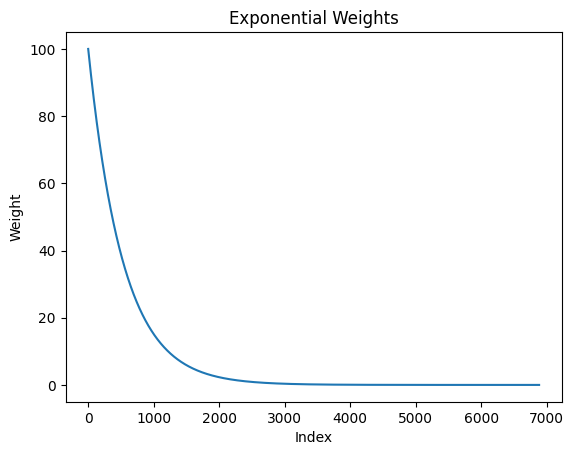

In [205]:
# Generate decreasing exponential weights
weights = 100*np.exp(np.linspace(0, -13, len(y_train_filt)))

# Plot the weights
plt.plot(weights)
plt.title('Exponential Weights')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.show()

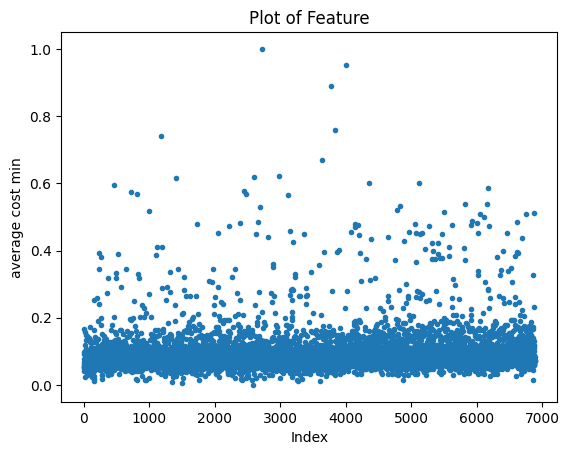

In [206]:
X_val1,y_val1 = val, val_target
y_train_df = pd.DataFrame(y_train, columns=['target'])
Combined_set = pd.concat([X_train, y_train_df], axis = 1 )
Combined_set.sort_values(by='average cost min')
Combined_set_sorted = Combined_set.sort_values(by='average cost min',  ascending=False)
plt.scatter(Combined_set.index, Combined_set["average cost min"], marker='.')
plt.ylabel("average cost min")
plt.xlabel("Index")
plt.title("Plot of Feature")
plt.show()

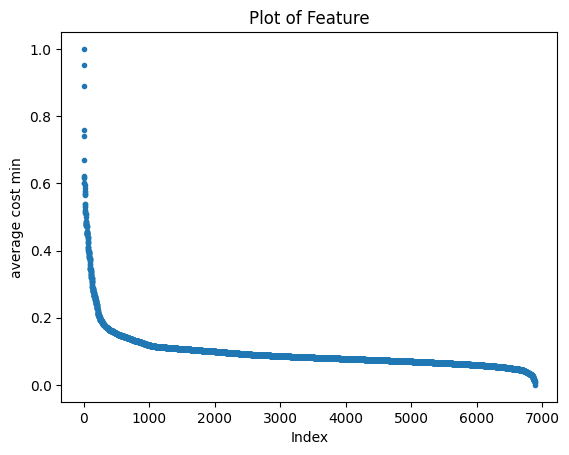

In [208]:
Combined_set_sorted = Combined_set_sorted.reset_index(drop=True)
X_train_filt = Combined_set_sorted.drop(columns = "target")
y_train_filt = Combined_set_sorted["target"]
plt.scatter(X_train_filt.index, X_train_filt["average cost min"], marker='.')
plt.ylabel("average cost min")
plt.xlabel("Index")
plt.title("Plot of Feature")
plt.show()

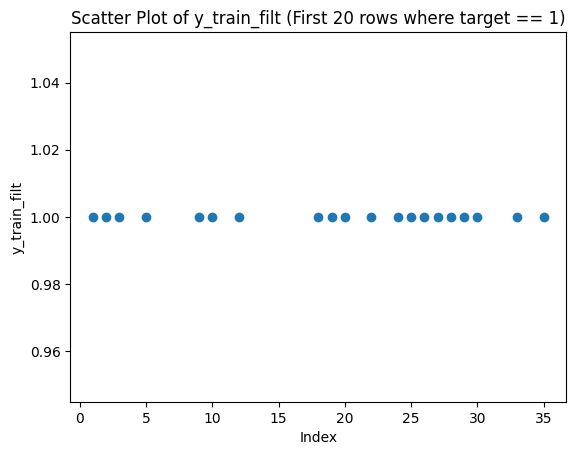

In [209]:
# Filter Combined_set_sorted to include only rows where 'target' is equal to 1
filtered_data = Combined_set_sorted[Combined_set_sorted["target"] == 1]

# Select the first 20 rows
filtered_data_first_20 = filtered_data.head(20)

# Get the target values from the filtered DataFrame
y_train_filt20 = filtered_data_first_20["target"]

# Plot a scatter plot of y_train_filt against the index
plt.scatter(filtered_data_first_20.index, y_train_filt20)
plt.title('Scatter Plot of y_train_filt (First 20 rows where target == 1)')
plt.xlabel('Index')
plt.ylabel('y_train_filt')
plt.show()

Firstly, basic models are trained for reference.

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix for Logistic Regression:
[[536 320]
 [ 29 124]]
AUC for Logistic Regression: 0.8013255146295277
Confusion matrix for Random Forest:
[[825  31]
 [ 96  57]]
AUC for Random Forest: 0.7909069390996275
Confusion matrix for BaggingClassifier:
[[806  50]
 [107  46]]
AUC for BaggingClassifier: 0.6969374198277442


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Age: object, L_O_S: object, Dropped_Calls: object, OffPeak_calls_Sum: object, OffPeak_mins_Sum: object, Weekend_calls_Sum: object, Weekend_mins_Sum: object, International_mins_Sum: object, AvePeak: object, AveOffPeak: object, AveWeekend: object, National_calls: object, AveNational: object, Dropped_calls_ratio: object, Mins_charge: object, call_cost_per_min: object, actual call cost: object, average cost min: object, OffPeak ratio: object, Weekend ratio: object, Nat-InterNat Ratio: object

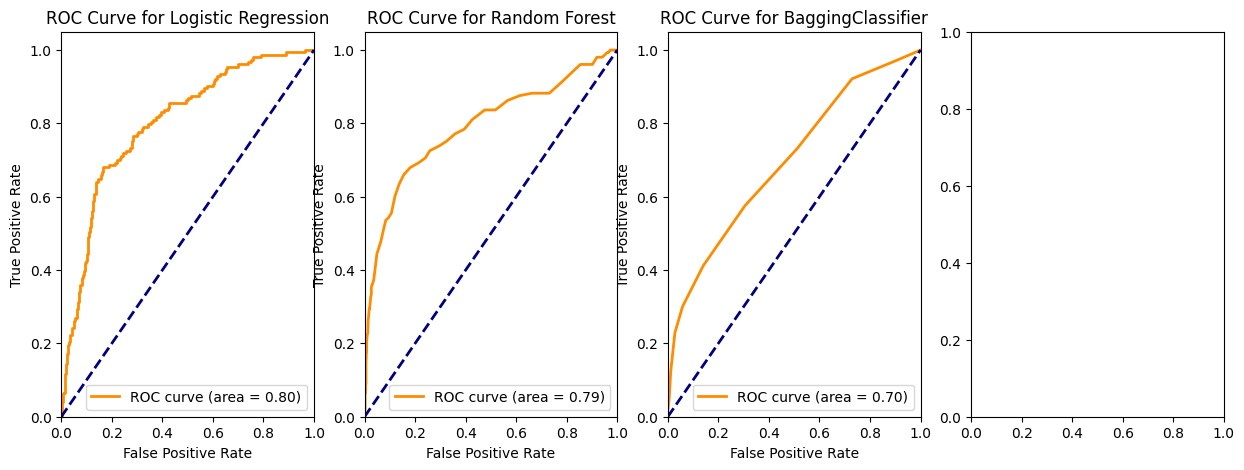

In [223]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'XGBClassifier': XGBClassifier(scale_pos_weight=20, objective='binary:logistic'),
    
}
plt.figure(figsize=(15, 5))  # Create a figure for subplots
for i, (name, model) in enumerate(models.items(), 1):
    weights = 100*np.exp(np.linspace(0, -13, len(y_train_filt)))

    plt.subplot(1, len(models), i)  # Create subplots
    # Train the model
    
    if model == XGBClassifier():
        gb = XGBClassifier()

        cats1 = X_train_filt.select_dtypes(exclude=np.number).columns.tolist()
        cats2 = X_val.select_dtypes(exclude=np.number).columns.tolist()
        cats3 = X_test.select_dtypes(exclude=np.number).columns.tolist()
        for col in cats1:
            X_train_filt[col] = X_train_filt[col].astype('float')
        for col in cats2:
            X_val[col] = X_val[col].astype('float')
        for col in cats3:
            X_test[col] = X_test[col].astype('float')
        
        gb.fit(X_train_filt, y_train_filt ,sample_weight=weights)   
        
    else:    
        
        model.fit(X_train_filt, y_train_filt ,sample_weight=weights)
    
    # Predict probabilities for the validation set
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)
    #pf = Profit_top_20(y_val, y_pred_proba, X_val)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    print(f"Confusion matrix for {name}:")
    print(cm)
    #print(f"Confusion matrix for {name}:")
    #print(pf)
    # Calculate AUC
    auc_score = roc_auc_score(y_val, y_pred_proba[:, 1])
    print(f"AUC for {name}: {auc_score}")#roc_auc
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

## Hyperparameter Tunning

First of all, the KFold is designed for randomized search. Due to the imbalance classification, the stratification is adopted. Besides, grid search runs for good especially when computation sources are limited. Instead, randomized search is used for its cost-efficiency. Mostly, randomized search has similar performance with grid search.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 1. Logistic regression

#### hyperparameters tunning

In [ ]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300, 400, 500]  # Maximum number of iterations
}

# Create RandomizedSearchCV with custom scoring
lr_rs = RandomizedSearchCV(lr, param_grid, cv=skf, scoring='roc_auc')
lr_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

# Print the best parameters and best score
print(lr_rs.best_params_)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 545.5594781168514}


In [ ]:
# Create a logistic regression model with the best parameters
lr_rs = LogisticRegression(**lr_rs.best_params_)
lr_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

LogisticRegression(C=545.5594781168514, max_iter=200, solver='liblinear')

### 2. Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Suppress warnings
#warnings.filterwarnings("ignore")

# Define the parameter grid
param_grid = {
    'n_estimators': np.arange(50, 301, 10),
    'max_depth': np.arange(1, 101, 5)
}

# Create GridSearchCV with custom scoring
rf_rs = RandomizedSearchCV(rf, param_grid, cv=skf, scoring = 'roc_auc', n_jobs=-1)
rf_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

# Print the best parameters and best score
print(rf_rs.best_params_)

{'n_estimators': 240, 'max_depth': 16}


In [ ]:
# Create a Random Forest model with the best parameters
rf_rs = RandomForestClassifier(**rf_rs.best_params_)

# Fit the model to the training data
rf_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

RandomForestClassifier(max_depth=16, n_estimators=240)

### 3. Bagging

In [ ]:
#hyperparameter grid
param_grid = {
    'n_estimators': np.arange(1,201,10),  # Number of base estimators
    'max_samples': [0.5, 0.7, 0.9, 1.0],  # Number of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 0.9, 1.0]  # Number of features to draw from X to train each base estimator
}

# Create RandomizedSearchCV with custom scoring
bag_rs = RandomizedSearchCV(bag, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

# Fit the model
bag_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

# Print the best parameters and best score
print(bag_rs.best_params_)

{'n_estimators': 141, 'max_samples': 0.7, 'max_features': 0.9}


In [ ]:
# Create a neural network model with the best parameters
bag_rs = BaggingClassifier(**bag_rs.best_params_)

# Fit the model to the training data
bag_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

BaggingClassifier(max_features=0.9, max_samples=0.7, n_estimators=141)

### 4. Boosting - Gradient Boosting

In [ ]:
# hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create RandomizedSearchCV with custom scoring
gb_rs = RandomizedSearchCV(gb, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

# Fit the model
gb_rs.fit(X_train_filt, y_train_filt ,sample_weight=weights)

# Print the best parameters and best score
print(gb_rs.best_params_)

{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
# Create a neural network model with the best parameters
gb_rs = XGBClassifier(**gb_rs.best_params_)

# Fit the model to the training data
gb_rs.fit(X_train_filt, y_train_filt ,sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Cross validation

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'BaggingClassifier': BaggingClassifier(),
     'XGBClassifier': XGBClassifier(),
    
}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_filt, y_train_filt, cv=kf, scoring='roc_auc',fit_params={'sample_weight': weights})  # Specify 'roc_auc' scoring
    results.append(cv_results)

# Plotting the results
plt.boxplot(results, labels=models.keys())
plt.title('Cross-Validation Results (AUC)')
plt.ylabel('AUC Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

## Model scoring and selection

In [ ]:
print('the score of logistic regression: ', profit_top_20(lr))
print('the score of random forest: ', profit_top_20(rf_rs))
print('the score of bagging: ', profit_top_20(bag_rs))
print('the score of gradient boosting: ', profit_top_20(gb))

the score of kNN:  cost    4.072154
dtype: float64
the score of decision tree:  cost    2.384775
dtype: float64
the score of logistic regression:  cost    3.529054
dtype: float64
the score of neural networks:  cost    3.506068
dtype: float64
the score of random forest:  cost    2.267141
dtype: float64
the score of bagging:  cost    2.513976
dtype: float64
the score of gradient boosting:  cost    3.237724
dtype: float64


In [ ]:
# retrive the result from the best model

y_pred_proba_test = gb.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv(os.path.join(os.path.expanduser('~'), 'Desktop', 'Model_Result_Final.csv'), index=False)